In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from multiprocessing import Pool, shared_memory
from scipy.stats import erlang, norm
from scipy.special import erf
import math

In [213]:
def create_Erlang_dist(lamb, k):
    def Erlang_dist(x):
        return erlang.pdf(x, k, scale=1/lamb)
    return Erlang_dist

def create_Erlang_cdf(lamb, k):
    def Erlang_cdf(x):
        return erlang.cdf(x, k, scale=1/lamb)
    return Erlang_cdf

def q1(r, mu, sigma):
    sqrt = np.sqrt
    pi = np.pi
    exp = np.exp 
    return (mu/2)*erf((r-mu)/sqrt(2*sigma*sigma)) - (sigma/sqrt(2*pi))*exp(-(r-mu)**2/(2*sigma*sigma))

def q2(r, mu, sigma, c):
    sqrt = np.sqrt
    pi = np.pi
    exp = np.exp    
    return ( .5*(1-(mu/c))*erf((r-mu)/sqrt(2*sigma*sigma))
            + (sigma/sqrt(2*pi*c*c))*exp(-(r-mu)**2/(2*sigma*sigma)))
def g(r, c):
    arcsin = np.arcsin
    pi = np.pi
    power = np.power
    return (.5 
            + (2*r/(3*c*pi)) 
            - (r/(c*pi))*power(1- (c/r)**2, 1/2)
            + (r/(3*c*pi))*power(1- (c/r)**2, 3/2)
            - (arcsin(c/r)/pi))

def alpha_exp(n ,lamb, c):
    return ((erlang.pdf(c, n, scale=1/lamb)/lamb) 
           + (1-(n/(c*lamb)))*erlang.cdf(c, n, scale=1/lamb))

def alpha_clt(n, mu, sigma, c):
    return (q2(c,mu, sigma, c) - q2(0,mu, sigma, c))

def gamma_exp(n ,lamb, c, warning=False, clt=False):
    dist_func = create_Erlang_dist(lamb, n)
    in1, err1 = integrate.quad(lambda r: r*dist_func(r),
                          0, 
                          c, epsabs=0,limit=1000)
    in2, err2 = integrate.quad(lambda r: g(r, c)*dist_func(r),
                                              c, 
                                              np.inf, epsabs=0, limit=1000)
    if  (err1 == 0 or err2 == 0) and warning:
        print(f"Warning in gamma_exp err1:{err1}, err2:{err2}")
        
    if (err1 == 0 or err2 == 0) and clt and (n/lamb) >= c:
        in2 = in2 = g(n/lamb, c)
        
    return (2/(3*c*np.pi))*in1 + in2

def gamma_clt(n, mu, sigma, c):
    sqrt = np.sqrt
    pi = np.pi
    f1 = (2/(3*pi*c))*(q1(c, n*mu, sqrt(n)*sigma)-q1(-c, n*mu, sqrt(n)*sigma))
    if c > n*mu:
        f2 = (2/(3*pi))*(2-erf((c-n*mu)/sqrt(2*n*sigma*sigma))-erf((c+n*mu)/sqrt(2*n*sigma*sigma)))
    else:
        f2 = g(n*mu, c)
    return f1+f2
        

# Test off-diagonals that sampled from exponential distribution

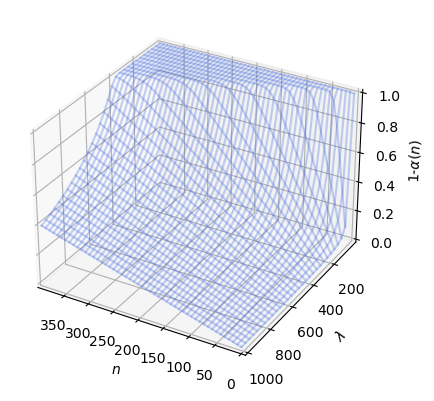

In [295]:
c=1
ns = 4*np.arange(1, 100, 2).astype(np.int32)#np.array([4, 8, 16, 32, 64, 128, 256])#, 512, 1024])
lambs = np.linspace(1, 1000, 30)# np.array([1, 10, 50, 100, 500])

alphas = np.array([[alpha_exp(n ,lamb, c) 
                             for n in ns]
                             for lamb in lambs ])


ax = plt.figure().add_subplot(projection='3d', azim=120)

for k,lamb in enumerate(lambs):
    ax.plot(ns, 1-alphas[k,:], zs=lamb, zdir='y',
            color='royalblue', alpha=.3)

for k,n in enumerate(ns):
    ax.plot(lambs, 1-alphas[:,k], zs=n, zdir='x',
            color='royalblue', alpha=.3)


ax.set(xlim=(0, ns[-1]), ylim=(lambs[0], lambs[-1]), zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\lambda$', zlabel=r'1-$\alpha(n)$')    
plt.show()

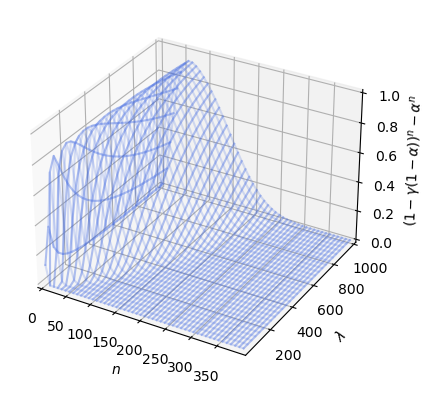

In [297]:
c=1
ns = 4*np.arange(1, 100, 2).astype(np.int32)#np.array([4, 8, 16, 32, 64, 128, 256])#, 512, 1024])
lambs = np.linspace(1, 1000, 30)# np.array([1, 10, 50, 100, 500])

alphas = np.array([[alpha_exp(n ,lamb, c) 
                             for n in ns]
                             for lamb in lambs ])
gammas = np.array([[gamma_exp(n ,lamb, c, clt=True) 
                             for n in ns]
                             for lamb in lambs ]) 

ax = plt.figure().add_subplot(projection='3d')

for k,lamb in enumerate(lambs):
    ax.plot(ns, (1-gammas[k,:]*(1-alphas[k,:]))**ns - alphas[k,:]**ns, zs=lamb, zdir='y',
            color='royalblue', alpha=.2)
    
for k,n in enumerate(ns):
    ax.plot(lambs, (1-gammas[:,k]*(1-alphas[:,k]))**n - alphas[:,k]**n, zs=n, zdir='x',
            color='royalblue', alpha=.4)    

ax.set(xlim=(0, ns[-1]), ylim=(lambs[0], lambs[-1]), zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\lambda$', zlabel=r'$(1-\gamma(1-\alpha))^n - \alpha^n$')    
plt.show()

# The effect of increasing c, or the upper bound for degradation rate:
## It acts like a scaling factor that zooms in.

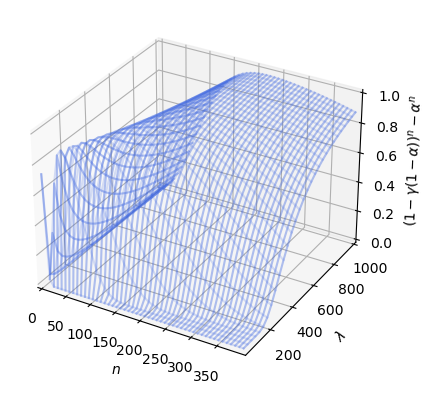

In [216]:
c=10
ns = 4*np.arange(1, 100, 2).astype(np.int32)#np.array([4, 8, 16, 32, 64, 128, 256])#, 512, 1024])
lambs = np.linspace(1, 1000, 30)# np.array([1, 10, 50, 100, 500])

alphas = np.array([[alpha_exp(n ,lamb, c) 
                             for n in ns]
                             for lamb in lambs ])
gammas = np.array([[gamma_exp(n ,lamb, c, clt=True) 
                             for n in ns]
                             for lamb in lambs ]) 

ax = plt.figure().add_subplot(projection='3d')

for k,lamb in enumerate(lambs):
    ax.plot(ns, (1-gammas[k,:]*(1-alphas[k,:]))**ns - alphas[k,:]**ns, zs=lamb, zdir='y',
            color='royalblue', alpha=.2)
    
for k,n in enumerate(ns):
    ax.plot(lambs, (1-gammas[:,k]*(1-alphas[:,k]))**n - alphas[:,k]**n, zs=n, zdir='x',
            color='royalblue', alpha=.4)    

ax.set(xlim=(0, ns[-1]), ylim=(lambs[0], lambs[-1]), zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\lambda$', zlabel=r'$(1-\gamma(1-\alpha))^n - \alpha^n$')    
plt.show()

# Test off-diagonals that modeled by CLT.

In [218]:
alphas.shape

(10, 50)

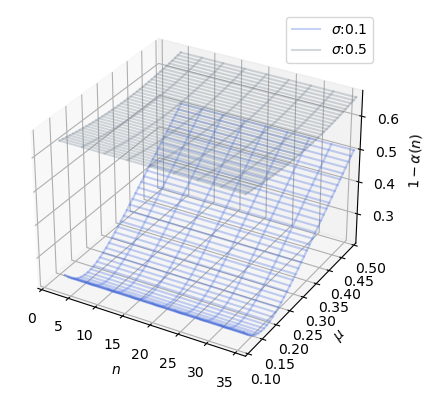

In [316]:
c=1
ns = 4*np.arange(1, 10).astype(np.int32)
sigmas = np.array([.1, .5])
ax = plt.figure().add_subplot(projection='3d')

colors = [ 'royalblue','slategray', 'navy']
for i,sigma in enumerate(sigmas):
    mus = np.linspace(0.1, .5, 40)

    alphas = np.array([[alpha_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for mu in mus ])
    

    for k,mu in enumerate(mus):
        
        ax.plot(ns, 1-alphas[k,:], zs=mu, zdir='y',
                color=colors[i%3], alpha=.3, label= (r"$\sigma$:" f"{sigma}" if k == 0 else ""))

    for k,n in enumerate(ns):
        ax.plot(mus, 1-alphas[:,k], zs=n, zdir='x',
                color=colors[i%3], alpha=.3)


ax.set(xlim=(0, ns[-1]), ylim=(mus[0], mus[-1]), #zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\mu$', zlabel=r'$1-\alpha(n)$')    
plt.legend()
plt.show()

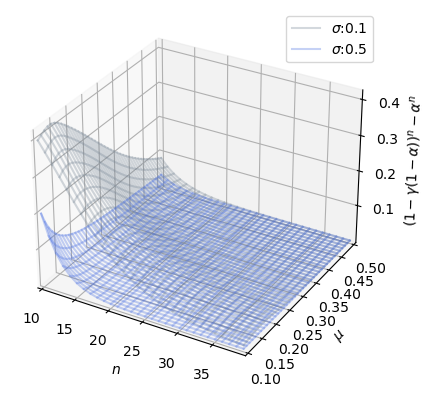

In [285]:
c=1
ns = np.arange(10, 40).astype(np.int32)
sigmas = np.array([.1,  .5])

ax = plt.figure().add_subplot(projection='3d')
colors = [ 'slategray', 'royalblue','navy']
for i,sigma in enumerate(sigmas):

    mus = np.linspace(0.1, .5, 40)

    alphas = np.array([[alpha_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for mu in mus ])

    gammas = np.array([[gamma_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for mu in mus ])


    for k,mu in enumerate(mus):
        
        ax.plot(ns, (1-gammas[k,:]*(1-alphas[k,:]))**ns - alphas[k,:]**ns, zs=mu, zdir='y',
                color=colors[i%3], alpha=.3, label= (r"$\sigma$:" f"{sigma}" if k == 0 else ""))

    for k,n in enumerate(ns):
        ax.plot(mus, (1-gammas[:,k]*(1-alphas[:,k]))**n - alphas[:,k]**n, zs=n, zdir='x',
                color=colors[i%3], alpha=.3)


ax.set(xlim=(ns[0], ns[-1]), ylim=(mus[0], mus[-1]), #zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\mu$', zlabel=r'$(1-\gamma(1-\alpha))^n - \alpha^n$')    
plt.legend()
plt.show()

# Effect of c

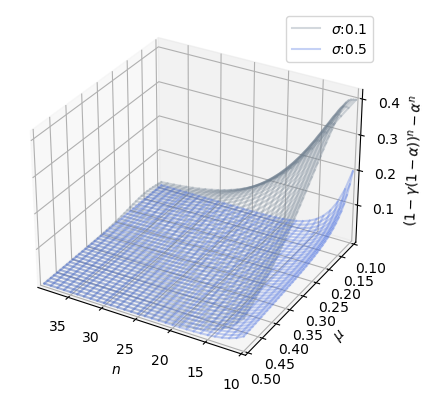

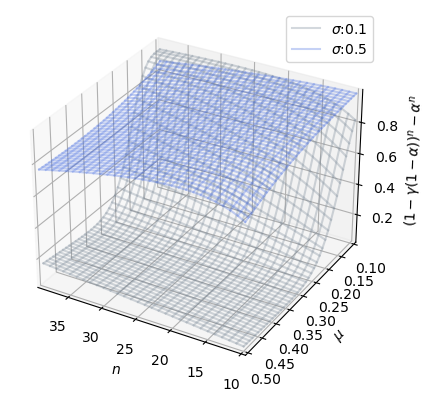

In [315]:
c=1
ns = np.arange(10, 40).astype(np.int32)
sigmas = np.array([.1, .5])

ax = plt.figure().add_subplot(projection='3d', azim=120)
colors = [ 'slategray', 'royalblue','navy']
for i,sigma in enumerate(sigmas):

    mus = np.linspace(0.1, .5, 40)

    alphas = np.array([[alpha_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for mu in mus ])

    gammas = np.array([[gamma_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for mu in mus ])


    for k,mu in enumerate(mus):
        
        ax.plot(ns, (1-gammas[k,:]*(1-alphas[k,:]))**ns - alphas[k,:]**ns, zs=mu, zdir='y',
                color=colors[i%3], alpha=.3, label= (r"$\sigma$:" f"{sigma}" if k == 0 else ""))

    for k,n in enumerate(ns):
        ax.plot(mus, (1-gammas[:,k]*(1-alphas[:,k]))**n - alphas[:,k]**n, zs=n, zdir='x',
                color=colors[i%3], alpha=.3)


ax.set(xlim=(ns[0], ns[-1]), ylim=(mus[0], mus[-1]), #zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\mu$', zlabel=r'$(1-\gamma(1-\alpha))^n - \alpha^n$')    
plt.legend()
plt.show()

c=100
ns = np.arange(10, 40).astype(np.int32)
sigmas = np.array([.1, .5])

ax = plt.figure().add_subplot(projection='3d', azim=120)
colors = [ 'slategray', 'royalblue','navy']
for i,sigma in enumerate(sigmas):

    mus = np.linspace(0.1, .5, 40)

    alphas = np.array([[alpha_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for mu in mus ])

    gammas = np.array([[gamma_clt(n ,mu, sigma, c) 
                                 for n in ns]
                                 for mu in mus ])


    for k,mu in enumerate(mus):
        
        ax.plot(ns, (1-gammas[k,:]*(1-alphas[k,:]))**ns - alphas[k,:]**ns, zs=mu, zdir='y',
                color=colors[i%3], alpha=.3, label= (r"$\sigma$:" f"{sigma}" if k == 0 else ""))

    for k,n in enumerate(ns):
        ax.plot(mus, (1-gammas[:,k]*(1-alphas[:,k]))**n - alphas[:,k]**n, zs=n, zdir='x',
                color=colors[i%3], alpha=.3)


ax.set(xlim=(ns[0], ns[-1]), ylim=(mus[0], mus[-1]), #zlim=(0, 1),
       xlabel=r'$n$', ylabel=r'$\mu$', zlabel=r'$(1-\gamma(1-\alpha))^n - \alpha^n$')    
plt.legend()
plt.show()